In [1]:
# Data manipulation
import pandas as pd
import numpy as np

import pandas_ta as ta

# load data
import yfinance as yf

In [2]:
# Data download
symbol = "EURUSD=X"
period ='60d'
interval ='1h'

In [3]:
'''
https://www.marketcalls.in/machine-learning/decoding-features-and-targets-in-machine-learning-the-keys-to-model-success.html
In machine learning, features represent the input data points or independent variables used to describe various aspects of the object under study. Targets, on the other hand, are the output or dependent variables that the model aims to predict or classify based on the input features.
'''

'\nhttps://www.marketcalls.in/machine-learning/decoding-features-and-targets-in-machine-learning-the-keys-to-model-success.html\nIn machine learning, features represent the input data points or independent variables used to describe various aspects of the object under study. Targets, on the other hand, are the output or dependent variables that the model aims to predict or classify based on the input features.\n'

[*********************100%***********************]  1 of 1 completed

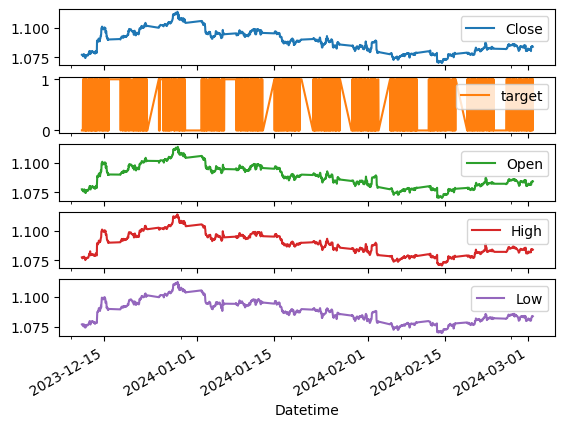

In [4]:
# load data
def get_yfinance_hist(symbol = "EURUSD=X", period ='1mo', interval ='15m', show_plot = True ):
    df_raw = yf.download(symbol,period= period ,interval=interval)
    df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
    df_raw.dropna(how="any",inplace=True)
    df_raw["target"] = np.where(df_raw["returns"].shift(1) > 0, 1, 0)
    df_raw = df_raw.drop('Volume', axis=1)

    if(show_plot):
      plot_cols = ['Close', 'target', 'Open', 'High', 'Low']
      plot_features = df_raw[plot_cols]
      plot_features.index = df_raw.index
      _ = plot_features.plot(subplots=True)

    df_raw = df_raw.dropna()

    return df_raw

df = get_yfinance_hist(symbol = symbol, period = period, interval= interval )

In [5]:
def add_signal_indicators(df):
    df['SMA_10'] = ta.sma(df['Adj Close'],length=10)
    df['SMA_30'] = ta.sma(df['Adj Close'],length=30)
    df['SMA_50'] = ta.sma(df['Adj Close'],length=50)
    df['SMA_200'] = ta.sma(df['Adj Close'],length=200)
    
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_hist'] = macd['MACDh_12_26_9']

    df['10_cross_30'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0)
    
    df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] < df['MACD'], 1, 0)
    
    df['MACD_lim'] = np.where(df['MACD']>0, 1, 0)
    
    df['abv_50'] = np.where((df['SMA_30']>df['SMA_50'])
                            &(df['SMA_10']>df['SMA_50']), 1, 0)
                            
    df['abv_200'] = np.where((df['SMA_30']>df['SMA_200'])
                            &(df['SMA_10']>df['SMA_200'])
                            &(df['SMA_50']>df['SMA_200']), 1, 0)
    
    return df


In [6]:

df = df.dropna()

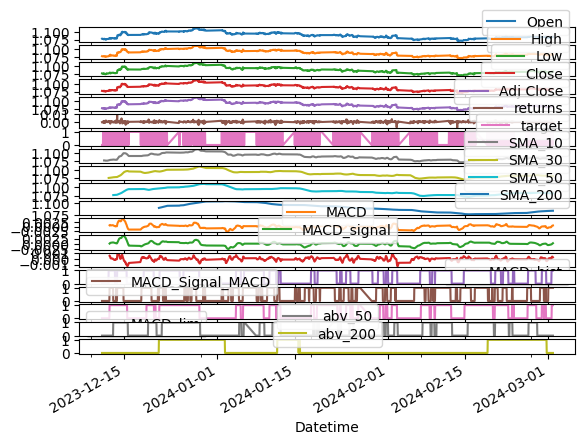

In [9]:
df_plot = add_signal_indicators(df)
#print(df_plot.columns)
#plot_cols = ['Close', 'SMA_10', 'SMA_30', 'SMA_50', 'SMA_200']
plot_cols = df_plot.columns
plot_features = df_plot[plot_cols]
plot_features.index = df_plot.index
_ = plot_features.plot(subplots=True)